In [15]:
import random
from pprint import pprint
import io
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
import time
import logging
from matplotlib.colors import ListedColormap

import tyssue
from tyssue import History
from tyssue.dynamics import effectors, model_factory, model_factory_vessel, model_factory_cylinder
from tyssue.generation.hexagonal_grids import hexa_cylinder
from tyssue.generation.shapes import sheet_from_cell_centers
from tyssue.geometry.sheet_geometry import CylinderGeometry, CylinderGeometryInit
from tyssue import config
from tyssue.draw import sheet_view, create_gif
from tyssue.geometry.vessel_geometry import VesselGeometry as geom
from tyssue.solvers.viscous import EulerSolver
from tyssue.draw.ipv_draw import browse_history
from tyssue.topology.sheet_topology import cell_division, drop_face, split_vert
from tyssue.topology.base_topology import remove_face
from tyssue.behaviors import EventManager
from tyssue.generation.modifiers import create_anchors
try:
    from ..behaviors.behaviors import *
except:
    print("Failed relative import, attempting direct import")
    from vivarium_tyssue.behaviors import *
import ipyvolume as ipv

from process_bigraph import Process, Composite, ProcessTypes
from process_bigraph.emitter import emitter_from_wires, gather_emitter_results

%load_ext snakeviz

Failed relative import, attempting direct import
The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [34]:
# def fix_points_cylinder(sheet, radius):
#     xy = sheet.vert_df[['x', 'y']].to_numpy()
#     r = np.linalg.norm(xy, axis=1)
#     r_safe = np.where(r == 0, 1e-12, r)
#     xy_on_cylinder = (radius/r_safe)[:, None] * xy
#     sheet.vert_df['x'] = xy_on_cylinder[:, 0]
#     sheet.vert_df['y'] = xy_on_cylinder[:, 1]

In [35]:
# def divide_cylinder(sheet, manager, geom, division_rate, dt, radius):
#     update_stem_cells(sheet)
#     stem_cells = sheet.face_df.loc[(sheet.face_df["stem_cell"] == 1) & (sheet.face_df["area"]>=0.7*sheet.face_df["area"].mean())].copy()
#     n_stem = len(stem_cells)
#     cell_ids = list(stem_cells["unique_id"])
#     n_divisions = np.random.binomial(n=n_stem, p=division_rate * dt)
#     dividing_cells = np.random.choice(cell_ids, size=n_divisions, replace=False)
#
#     for cell_id in dividing_cells:
#         cell_idx = int(sheet.face_df[sheet.face_df["unique_id"] == cell_id].index[0])
#         daughter = cell_division(sheet, cell_idx, geom)
#     manager.append(divide_cylinder, geom=geom, division_rate=division_rate, dt=dt, radius=radius)
#     fix_points_cylinder(sheet, radius=radius)

In [36]:
# def apoptosis_cylinder(sheet, manager, death_rate, dt, radius, geom):
#     update_stem_cells(sheet)
#     dying_cells = sheet.face_df.loc[sheet.face_df["dying_cell"] == 1]
#     n_dying = len(dying_cells)
#     cell_ids = list(dying_cells["unique_id"])
#     n_deaths = np.random.binomial(n=n_dying, p=death_rate * dt)
#     to_kill = np.random.choice(cell_ids, size=n_deaths, replace=False)
#
#     for cell_id in to_kill:
#         cell_idx = int(sheet.face_df[sheet.face_df["unique_id"] == cell_id].index[0])
#         # if sheet.face_df.loc[cell_idx, "boundary"] == 0:
#         vertex = remove_face(sheet, cell_idx)
#         # else:
#         #     vertex = drop_face(sheet, cell_idx, geom)
#         # split_vert(sheet, vertex)
#     manager.append(apoptosis_cylinder, death_rate=death_rate, dt=dt, radius=radius, geom=geom)
#     fix_points_cylinder(sheet, radius=radius)

In [2]:
def auto_correlated_tension(sheet, manager, sigma, phi):
    """
    Parameters:
    sheet: tyssue.Sheet object
    manager: EventManager object
    sigma: float, standard deviation
    phi: float, autocorrelation factor between 0 and 1 (AR(1) autocorrelation factor)
        closer to 1 means stronger correlation
    Returns:
    updates sheet.edge_df["line_tension"]
    """
    noise = np.random.normal(loc=0, scale=sigma, size=len(sheet.edge_df["line_tension"]))
    sheet.edge_df["line_tension"] =  phi * sheet.edge_df["line_tension"] + noise
    manager.append(auto_correlated_tension, sigma=sigma, phi=phi)

In [38]:
# def update_stem_cells(eptm):
#     eptm.face_df['stem_cell'] = 0
#     eptm.face_df['dying_cell'] = 0
#     eptm.face_df.loc[(eptm.face_df["boundary"] != 1) & (eptm.face_df["z"] < 0), "stem_cell"] = 1
#     eptm.face_df.loc[(eptm.face_df["z"] > 0), "dying_cell"] = 1

In [3]:
radius = 2.576
#generate cylindrical tissue
points_xyz = hexa_cylinder(16,30, radius = radius, noise = 0.0, capped = True)
sheet = sheet_from_cell_centers(points_xyz)
sheet = sheet.extract_bounding_box(z_boundary = (-10.1, 30), coords=['x', 'y', 'z'])
sheet.sanitize(trim_borders=False)
create_anchors(sheet)
sheet = sheet.extract_bounding_box(z_boundary = (-10.1, 10), coords=['x', 'y', 'z'])
sheet.sanitize(trim_borders=False)
geom.update_all(sheet)
sheet.network_changed = False

/Users/tasnifrahman/PycharmProjects/vivatyssue/src/tyssue/generation/modifiers.py:193: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet.edge_df = pd.concat([sheet.edge_df, anchor_edge_df], sort=True)


In [4]:
sheet.face_df.loc[(sheet.face_df["z"]<8) & (sheet.face_df["z"]>-8), "area"].mean()

np.float64(1.0001577509936472)

In [29]:
colors = ["green", "coral", "pink", "yellow", "purple"]
cmap = ListedColormap(colors)
sheet.face_df["color"] = 0
sheet.face_df.loc[(sheet.face_df["z"]<-5), "color"] = 1
sheet.face_df.loc[(sheet.face_df["z"]>-5) & (sheet.face_df["z"]<0), "color"] = 2
goblet_fraction = 0.2
enterocyte_fraction = 0.15
gob_to_replace = int(len(sheet.face_df) * goblet_fraction)
gob_indices = np.random.choice(sheet.face_df.loc[(sheet.face_df["z"]>0)].index, size=gob_to_replace)
sheet.face_df.loc[gob_indices, "color"] = 3

ent_to_replace = int(len(sheet.face_df) * enterocyte_fraction)
ent_indices = np.random.choice(sheet.face_df.loc[(sheet.face_df["z"]>0) & (sheet.face_df["color"] != 3)].index, size=ent_to_replace)
sheet.face_df.loc[ent_indices, "color"] = 4

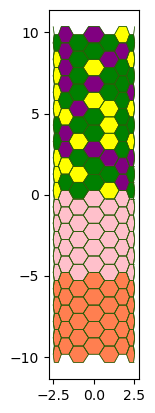

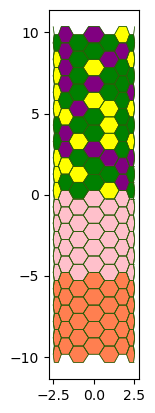

In [30]:
draw_specs = tyssue.config.draw.sheet_spec()
draw_specs["face"]["visible"] = True
draw_specs["face"]["visible"] = True
draw_specs["face"]["alpha"] = 1
draw_specs["face"]["color"] = cmap(sheet.face_df["color"])

fig, ax = sheet_view(sheet, coords=['x', 'z'], mode="2D", dpi=300, **draw_specs)
fig

In [42]:
#generate model
model = model_factory_vessel([
    effectors.LineTension,
    effectors.FaceAreaElasticity,
    effectors.PerimeterElasticity,
], effectors.FaceAreaElasticity)

In [43]:
#set model parameters
sheet.face_df["area_elasticity"] = 1
sheet.face_df["prefered_area"] = 1
sheet.face_df["perimeter_elasticity"] = 1
sheet.face_df["prefered_perimeter"] = 3.5
sheet.edge_df["line_tension"] = np.random.normal(loc=0, scale=0.01, size=len(sheet.edge_df))
sheet.edge_df["is_active"] = 1
sheet.vert_df["viscosity"] = 5
sheet.vert_df["prefered_deviation"] = 0
sheet.vert_df["surface_elasticity"] = 5
sheet.settings["threshold_length"] = 0.1
geom.update_all(sheet)

In [44]:
sheet.edge_df["face"]

edge
0       123
1       123
2       123
3       123
4       123
       ... 
1915    284
1916    284
1917    284
1918    284
1919     68
Name: face, Length: 1920, dtype: int64

In [45]:
history = History(sheet)

In [46]:
#set time-step
dt=0.1

In [47]:
#initialize manager and add division and apoptosis
#set division and apoptosis parameters
manager = EventManager()
manager.append(divide_cylinder, geom=geom, division_rate=0.0005, dt=dt, radius=radius)
manager.append(apoptosis_cylinder, death_rate=0.0005, dt=dt, radius=radius, geom=geom)
manager.append(auto_correlated_tension, sigma = 0.01, phi=0.5)

In [48]:
#initialize solver
solver = EulerSolver(
    sheet,
    geom,
    model,
    history=history,
    auto_reconnect=True,
    manager=manager,
)

In [49]:
sheet.edge_df["is_active"]

edge
0       1
1       1
2       1
3       1
4       1
       ..
1915    1
1916    1
1917    1
1918    1
1919    1
Name: is_active, Length: 1920, dtype: int64

In [ ]:
#set time variables
dt = dt
tf = 2000
sheet.settings["dt"] = dt
sheet.settings["p_4"] = 1/(dt)
sheet.settings["p_5p"] = 1/(dt)
#run simulation
start = time.time()
res = solver.solve(tf=tf, dt = dt)
print(f"Time Elapsed: {time.time()-start}")

In [19]:
sheet.edge_df

,at_border,boundary,cell,cell_o,cx,cy,cz,dx,dy,dz,...,trgt,trgt_o,tx,ty,tz,unique_id,unique_id_max,ux,uy,uz
edge,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0.0,0.0,0.0,0.032651,0.161414,-0.191746,...,128,842,-2.507246,0.591181,-5.145116,12,6120,0.129179,0.638606,-0.758610
1,0,0,0,0,0.0,0.0,0.0,-0.215514,0.675582,0.411121,...,491,841,-2.538551,-0.437646,-6.583725,14,6120,-0.262900,0.824123,0.501515
2,0,0,0,0,0.0,0.0,0.0,0.013198,-0.577271,-0.177762,...,211,843,-2.552502,-0.347144,-6.125888,20,6120,0.021844,-0.955436,-0.294212
3,0,0,0,0,0.0,0.0,0.0,0.785330,0.333331,-0.338864,...,253,593,1.385236,-2.171842,9.336233,21,6120,0.855597,0.363155,-0.369184
4,0,0,0,0,0.0,0.0,0.0,0.027642,0.006458,-0.571208,...,65,591,0.599906,-2.505172,9.675097,46,6120,0.048332,0.011293,-0.998768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1705,0,0,0,0,0.0,0.0,0.0,0.169586,-0.103709,-0.076343,...,597,575,-1.258147,-2.247853,-6.709700,234,6120,0.792337,-0.484545,-0.356690
1706,0,0,0,0,0.0,0.0,0.0,0.374195,-0.171838,0.393733,...,554,730,-0.884482,-2.419394,-7.173537,685,6120,0.657683,-0.302022,0.692022
1707,0,0,0,0,0.0,0.0,0.0,-0.374195,0.171838,-0.393733,...,598,730,-1.258678,-2.247556,-7.567270,685,6120,-0.657683,0.302022,-0.692022


In [20]:
ipv.clear()

In [30]:
ipv.clear()
browse_history(history,**draw_specs)

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

interactive(children=(IntSlider(value=0, description='i', max=20000), Output()), _dom_classes=('widget-interac…

In [22]:
len(sheet.face_df)

289

In [23]:
sheet.edge_df["is_active"]

edge
0       1
1       1
2       1
3       1
4       1
       ..
1705    1
1706    1
1707    1
1708    1
1709    1
Name: is_active, Length: 1710, dtype: int64

In [31]:
ipv.clear()
fig, mesh = sheet_view(sheet, coords=['x', 'y', 'z'], mode="3D", **draw_specs)
ipv.pylab.xyzlabel("x-axis", "y-axis", "z-axis")
ipv.pylab.style.axes_on()
fig

Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.0, position=(0.0,…

In [25]:
sheet1 = history.retrieve(0.0)

In [26]:
sheet.edge_df

,at_border,boundary,cell,cell_o,cx,cy,cz,dx,dy,dz,...,trgt,trgt_o,tx,ty,tz,unique_id,unique_id_max,ux,uy,uz
edge,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0.0,0.0,0.0,0.032651,0.161414,-0.191746,...,128,842,-2.507246,0.591181,-5.145116,12,6120,0.129179,0.638606,-0.758610
1,0,0,0,0,0.0,0.0,0.0,-0.215514,0.675582,0.411121,...,491,841,-2.538551,-0.437646,-6.583725,14,6120,-0.262900,0.824123,0.501515
2,0,0,0,0,0.0,0.0,0.0,0.013198,-0.577271,-0.177762,...,211,843,-2.552502,-0.347144,-6.125888,20,6120,0.021844,-0.955436,-0.294212
3,0,0,0,0,0.0,0.0,0.0,0.785330,0.333331,-0.338864,...,253,593,1.385236,-2.171842,9.336233,21,6120,0.855597,0.363155,-0.369184
4,0,0,0,0,0.0,0.0,0.0,0.027642,0.006458,-0.571208,...,65,591,0.599906,-2.505172,9.675097,46,6120,0.048332,0.011293,-0.998768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1705,0,0,0,0,0.0,0.0,0.0,0.169586,-0.103709,-0.076343,...,597,575,-1.258147,-2.247853,-6.709700,234,6120,0.792337,-0.484545,-0.356690
1706,0,0,0,0,0.0,0.0,0.0,0.374195,-0.171838,0.393733,...,554,730,-0.884482,-2.419394,-7.173537,685,6120,0.657683,-0.302022,0.692022
1707,0,0,0,0,0.0,0.0,0.0,-0.374195,0.171838,-0.393733,...,598,730,-1.258678,-2.247556,-7.567270,685,6120,-0.657683,0.302022,-0.692022


In [32]:
ipv.clear()
browse_history(history, **draw_specs)

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

interactive(children=(IntSlider(value=0, description='i', max=20000), Output()), _dom_classes=('widget-interac…

In [28]:
sheet.vert_df

,x,y,z,is_active,rho,height,basal_shift,unique_id,unique_id_max,srce_o,boundary,at_border,is_anchor,tx,ty,tz,viscosity,prefered_deviation,surface_elasticity
vert,,,,,,,,,,,,,,,,,,,
0,1.500952,2.093542,-1.916297,1,0.395461,0.0,4.0,16,1020,18,0,0,0,0.812710,-0.582668,0.0,5,0,5
1,1.683935,1.949395,-1.846146,1,0.395461,0.0,4.0,17,1020,19,0,0,0,0.756753,-0.653701,0.0,5,0,5
2,-2.569870,0.177614,5.925619,1,0.396587,0.0,4.0,42,1020,44,0,0,0,0.068949,0.997620,-0.0,5,0,5
3,-1.945438,-1.688505,6.563660,1,0.396640,0.0,4.0,51,1020,53,0,0,0,-0.655475,0.755216,0.0,5,0,5
4,-0.930430,-2.402098,6.198123,1,0.396640,0.0,4.0,52,1020,54,0,0,0,-0.932492,0.361192,0.0,5,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,1.120934,2.319328,-1.702715,1,0.395618,0.0,4.0,592,1020,639,0,0,0,0.900360,-0.435145,0.0,5,0,5
595,0.298182,2.558684,-2.582596,1,0.395298,0.0,4.0,595,1020,642,0,0,0,0.993278,-0.115754,0.0,5,0,5
596,-1.556957,-2.052233,3.609797,1,0.396381,0.0,4.0,280,1020,294,0,0,0,-0.796674,0.604409,0.0,5,0,5
